In [1]:
# testing setup for ndim local search

In [2]:
# # imports
# import torch
# from dataclasses import dataclass
# from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
# from botorch import fit_gpytorch_mll
# from botorch.optim import optimize_acqf
# from botorch.models.gp_regression import SingleTaskGP
# from gpytorch.mlls import ExactMarginalLogLikelihood
# # from extremasearch.acquisition.turbo import *
# # from extremasearch.acquisition.tead import *
# from typing import Callable
# from botorch.sampling import SobolQMCNormalSampler
# from botorch.models.transforms import Normalize, Standardize
#
# # n-dim update imports
# from extremasearch.acquisition.qtead import nglobal_tead
# from extremasearch.acquisition.nturbo import NdTurboState, ngenerate_batch, nd_new_update_state
#
# # setup
# dtype = torch.double
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MC_SAMPLES = 256
# N_CANDIDATES = min(5000, max(2000, 200 * 1))  # changes if dim =! 1
# RAW_SAMPLES = 512
# NUM_RESTARTS = 10
# BATCH_SIZE = 1  # changes if batch size > 1 used
# # bounds = torch.tensor([0.0, 1.0], device=device, dtype=dtype).unsqueeze(-1)  # changes if input bounds not 0-1
#
#
# def noptimize_acqf_and_get_next_x(acq_func, bounds):
#     """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
#     candidates, _ = optimize_acqf(
#         acq_function=acq_func,
#         bounds=bounds,
#         q=BATCH_SIZE,
#         num_restarts=NUM_RESTARTS,
#         raw_samples=RAW_SAMPLES,  # initialization heuristic
#         options={"batch_limit": 5, "maxiter": 200},
#     )
#     # observe new values
#     new_x = candidates.detach()
#     return new_x
#
#
# @dataclass
# class NdLocalSearchState:
#     """Holds the local search state information to be updated by running the search"""
#     input_dim: int
#     local_bounds: torch.Tensor  # will be torch.stack([lb, ub]) where lb, ub in shape (dim,1)
#     x_local: torch.Tensor
#     y_local: torch.Tensor
#     trust_region: NdTurboState = None
#     x_local_extreme: torch.Tensor = None
#     y_local_extreme: torch.Tensor = None
#     local_model: SingleTaskGP = None
#     local_mll: ExactMarginalLogLikelihood = None
#     most_recent_x_local: torch.Tensor = None
#     most_recent_y_local: torch.Tensor = None
#
#
# def initialize_model(train_x, train_obj, state_dict=None):
#     """function to initialize the GP model"""
#     model_obj = SingleTaskGP(train_x, train_obj)
#     mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
#     # load state_dict if it is not passed
#     if state_dict is not None:
#         model_obj.load_state_dict(state_dict)
#     return mll, model_obj
#
#
# def initialize_scaled_model(train_x, train_obj, state_dict=None):
#     """function to initialize the GP model with scaling on outputs and normalization on inputs"""
#     model_obj = SingleTaskGP(train_x, train_obj, outcome_transform=Standardize(m=train_obj.shape[-1]),
#                              input_transform=Normalize(d=train_x.shape[-1]))
#     mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
#     # load state_dict if it is not passed
#     if state_dict is not None:
#         model_obj.load_state_dict(state_dict)
#     return mll, model_obj
#
#
# @dataclass
# class SearchIterationData:
#     """Holds data on each search iteration to simplify adding and accessing the data"""
#     x: torch.Tensor = None
#     y: torch.Tensor = None
#     acq_type: str = None
#     iter_num: int = None
#
#
# @dataclass
# class NdLocalExtremeSearch:
#     """Runs the local search to update the local search state"""
#     max_local_evals: int
#     min_local_init_evals: int
#     local_state: NdLocalSearchState
#     dim: int
#     partition_length: torch.tensor = torch.tensor(1.0, dtype=dtype)
#     objective_function: Callable = None
#     length_history: torch.Tensor = None
#     # tr_bound_history: torch.Tensor = None
#     search_history: list[SearchIterationData] = None
#     iteration_tracker: int = None
#     iteration_limit: int = None
#     batch_size: int = 1
#
#     def initialize_local_search(self):
#         """Set up the local search object"""
#         # set up state object
#         # check initial data
#         x_initial = self.local_state.x_local
#         self.search_history = []
#         if self.iteration_tracker is None:
#             self.iteration_tracker = 0
#         # check against iteration limit
#         iterations_available = 9999999
#         if self.iteration_limit is not None and self.iteration_tracker is not None:
#             iterations_available = self.iteration_limit - self.iteration_tracker
#         # if not enough initial data points in local subdomain, sample more randomly todo: sobol or lhs, ndim
#         if x_initial.shape[0] < self.min_local_init_evals and iterations_available >= 1:
#             # sample randomly in subdomain to get to min
#             num_new = self.min_local_init_evals - x_initial.shape[0]
#             print('Making ', num_new, ' mcs evaluations to start local search')
#             if self.iteration_limit is not None and self.iteration_tracker is not None:
#                 num_new = min(num_new, abs(iterations_available))
#             new_x = torch.rand(num_new, self.dim, device=device, dtype=dtype)
#             local_x = new_x * (self.local_state.local_bounds[1] - self.local_state.local_bounds[0])  # apply range
#             local_x = local_x + self.local_state.local_bounds[0]  # apply floor
#             new_y = self.objective_function(local_x)
#             # update local data set
#             self.local_state.x_local = torch.cat((self.local_state.x_local, local_x), 0)
#             self.local_state.y_local = torch.cat((self.local_state.y_local, new_y), 0)
#             # update iteration data tracking
#             self.iteration_tracker += local_x.shape[0]
#             for i in range(0, self.iteration_tracker):
#                 current_data = SearchIterationData(x=local_x, y=new_y, acq_type='mcs', iter_num=self.iteration_tracker)
#                 self.search_history.append(current_data)
#             # store new evaluations to add to global data set later, overwriting any previous
#             self.local_state.most_recent_x_local = local_x
#             self.local_state.most_recent_y_local = new_y
#         else:
#             # make sure new evaluations data reset
#             self.local_state.most_recent_x_local = None
#             self.local_state.most_recent_y_local = None
#         # initialize gp model
#         gp_x = self.local_state.x_local
#         gp_y = self.local_state.y_local
#         self.local_state.local_mll, self.local_state.local_model = initialize_scaled_model(gp_x, gp_y, None)
#
#     def run_local_search(self, acq_type: str = 'turbo'):
#         """Run the search based on the local starting point"""
#         # initialize local search
#         self.initialize_local_search()
#         # local search loop
#         converged = False
#         local_iter = 0
#         # initialize turbo trust region
#         # setting the bounds to constrain the turbo search to the selected subdomain
#         x_cur_center = self.local_state.x_local[self.local_state.y_local.argmax(), :].clone()
#         self.local_state.trust_region = NdTurboState(dim=self.dim,
#                                                      batch_size=self.batch_size,
#                                                      center=x_cur_center,
#                                                      lb=self.local_state.local_bounds[0],
#                                                      ub=self.local_state.local_bounds[1],
#                                                      length=0.25*self.partition_length,
#                                                      domain_constraints=self.local_state.local_bounds,
#                                                      length_max=0.5*self.partition_length
#                                                      )
#         self.local_state.trust_region = nd_new_update_state(self.local_state.trust_region,
#                                                             self.local_state.x_local,
#                                                             self.local_state.y_local,
#                                                             self.local_state.y_local.max()
#                                                             )
#         # check iteration limit before starting search
#         if self.iteration_limit is not None and self.iteration_tracker is not None:
#             if self.iteration_tracker >= self.iteration_limit:
#                 converged = True
#         # loop to run local search iterations
#         while not converged and local_iter <= self.max_local_evals:
#             # fit the gp model
#             self.fit_local_model()
#             # run the acquisition function
#             if acq_type == 'turbo':
#                 next_x = ngenerate_batch(state=self.local_state.trust_region,
#                                          model=self.local_state.local_model,
#                                          dim=self.dim,
#                                          x=self.local_state.x_local,
#                                          y=self.local_state.y_local,
#                                          batch_size=self.batch_size,
#                                          n_candidates=N_CANDIDATES,
#                                          num_restarts=NUM_RESTARTS,
#                                          raw_samples=RAW_SAMPLES,
#                                          acqf='ts',
#                                          )
#                 print('turbo')
#             elif acq_type == 'tead':
#                 next_x = nglobal_tead(self.local_state.local_model)
#                 print('tead')
#             elif acq_type == 'nei':
#                 qmc_sampler = SobolQMCNormalSampler(MC_SAMPLES)
#                 qNEI = qNoisyExpectedImprovement(model=self.local_state.local_model,
#                                                  X_baseline=self.local_state.x_local,
#                                                  sampler=qmc_sampler,
#                                                  )
#                 next_x = noptimize_acqf_and_get_next_x(qNEI, self.local_state.local_bounds)
#             else:
#                 print('Error: unknown acquisition function for local search')
#             next_y = self.objective_function(next_x)
#             # update x,y data points
#             # local x,y values
#             self.local_state.x_local = torch.cat((self.local_state.x_local, next_x), 0)
#             self.local_state.y_local = torch.cat((self.local_state.y_local, next_y), 0)
#             # search history
#             current_data = SearchIterationData(x=next_x, y=next_y, acq_type=acq_type, iter_num=self.iteration_tracker)
#             self.search_history.append(current_data)
#             self.iteration_tracker += 1
#             # new x,y values from this local search only
#             if self.local_state.most_recent_x_local is not None:
#                 self.local_state.most_recent_x_local = torch.cat((self.local_state.most_recent_x_local, next_x), 0)
#                 self.local_state.most_recent_y_local = torch.cat((self.local_state.most_recent_y_local, next_y), 0)
#             else:
#                 self.local_state.most_recent_x_local = next_x
#                 self.local_state.most_recent_y_local = next_y
#             # update trust region
#             # print(max(self.local_state.y_local))
#             self.local_state.trust_region = nd_new_update_state(self.local_state.trust_region,
#                                                                 x_train=self.local_state.x_local,
#                                                                 y_train=self.local_state.y_local,
#                                                                 y_next=self.local_state.y_local.max()
#                                                                 )
#             # update local model - using only local training samples inside the updated trust region
#             x_in_region, y_in_region = self.local_state.trust_region.get_training_samples_in_region()
#             if acq_type == 'turbo':
#                 self.local_state.local_mll, \
#                     self.local_state.local_model = initialize_scaled_model(x_in_region,
#                                                                            y_in_region, None)
#             elif acq_type == 'tead':
#                 self.local_state.local_mll, \
#                     self.local_state.local_model = initialize_scaled_model(self.local_state.x_local,
#                                                                            self.local_state.y_local,
#                                                                            None)
#             else:
#                 self.local_state.local_mll, \
#                     self.local_state.local_model = initialize_scaled_model(self.local_state.x_local,
#                                                                            self.local_state.y_local,
#                                                                            None)
#                 print('Error: unknown acquisition function for local search')
#             local_iter += 1
#             if self.local_state.trust_region.restart_triggered:
#                 converged = True
#             if self.iteration_limit is not None and self.iteration_tracker is not None:
#                 if self.iteration_tracker >= self.iteration_limit:
#                     converged = True
#         # exit local search and return results
#         local_search_extreme_y = self.local_state.y_local.max()
#         extreme_idx = self.local_state.y_local.argmax()
#         local_search_extreme_x = self.local_state.x_local[extreme_idx]
#         self.local_state.x_local_extreme = local_search_extreme_x
#         self.local_state.y_local_extreme = local_search_extreme_y
#         return self.search_history
#
#     def fit_local_model(self):
#         """Fit the local model"""
#         # update local model including scaling and normalization from data in current trust region
#         # get the data in the current trust region
#         # set up the model and mll using the normalization and scaling
#
#         fit_gpytorch_mll(self.local_state.local_mll)

In [3]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from botorch import fit_gpytorch_mll

from extremasearch.local.ndlocalsearch import NdLocalSearchState, NdLocalExtremeSearch

# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\alexb\PycharmProjects\extrema_search\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


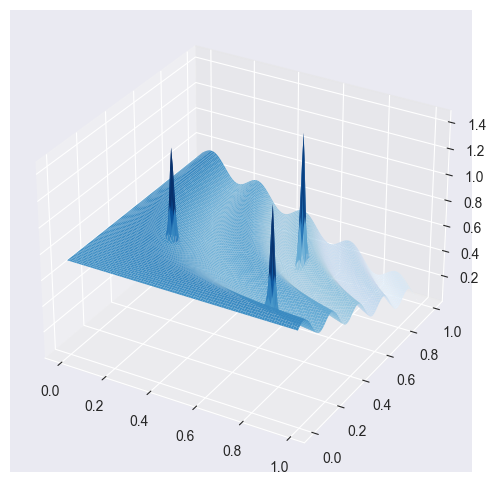

In [4]:
import matplotlib.pyplot as plt
# and with addition of smooth global behavior
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)

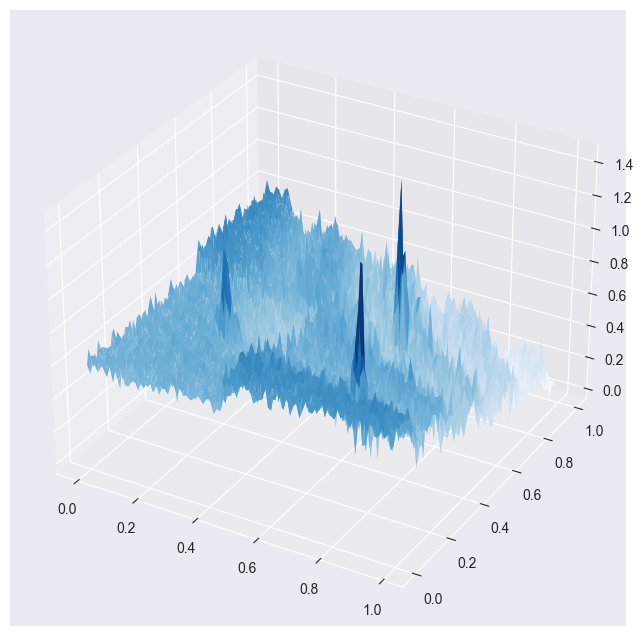

In [5]:
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)

In [6]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [15]:
x_train = torch.tensor([[0.61, 0.61]], dtype=dtype)

In [16]:
y_train = outcome_objective(x_train)

In [17]:
test_local_bounds = torch.tensor([[0.55, 0.55],[0.7, 0.7]], dtype=dtype)
test_local_bounds

tensor([[0.5500, 0.5500],
        [0.7000, 0.7000]], dtype=torch.float64)

In [18]:
test_nd_local_search_state = NdLocalSearchState(input_dim=x_train.shape[-1], local_bounds=test_local_bounds,
                                                x_local=x_train, y_local=y_train)

In [19]:
test_nd_local_search = NdLocalExtremeSearch(15, 2, test_nd_local_search_state, x_train.shape[-1],
                                            torch.tensor(0.15, dtype=dtype), objective_function=outcome_objective)

In [20]:
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

cur_hist = test_nd_local_search.run_local_search()

Making  1  mcs evaluations to start local search
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo

TuRBO restart triggered


(0.0, 1.0)

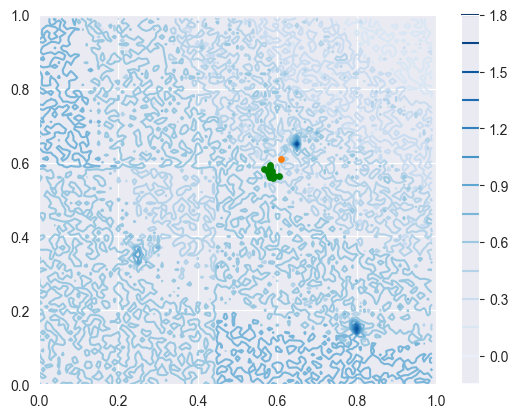

In [21]:
train_x_turbo = test_nd_local_search.local_state.x_local
train_obj_turbo = test_nd_local_search.local_state.y_local

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
ax1.scatter(train_x_turbo[:,0].numpy()[0:1], train_x_turbo[:,1].numpy()[0:1], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(train_x_turbo[:,0].numpy()[1:], train_x_turbo[:,1].numpy()[1:], s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])

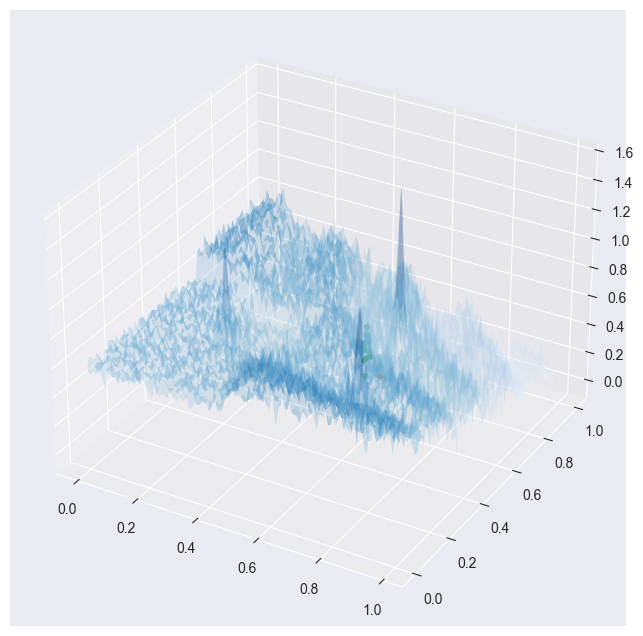

In [22]:
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_turbo[:,0].numpy()[0:1], train_x_turbo[:,1].numpy()[0:1], train_obj_turbo.numpy()[0:1], marker='.', color='tab:orange', s=40)
ax.scatter(train_x_turbo[:,0].numpy()[1:], train_x_turbo[:,1].numpy()[1:], train_obj_turbo.numpy()[1:], marker='.', color='g', s=40)